In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Brain import Neuron, GMM
import warnings
warnings.filterwarnings('ignore')

p_mean = 0.5
p_sig = 0.045
p = GMM([1.0], np.array([[p_mean,p_sig]]))
q = Neuron([1,1], np.array([0.5]), p_sig*p_sig)
lims = [0,1]

x_vals = np.linspace(lims[0],lims[1],1000)
p_vals = p(x_vals)
q_vals = q(np.array(x_vals).reshape(-1,1),update=False)
fig = plt.figure(figsize=(12,5))
plt.plot(x_vals, p_vals, label="$p(x)$")
plt.plot(x_vals, q_vals, label="$q(x)$")
plt.plot(x_vals, p_vals*q_vals, label="$p(x)q(x)$")
plt.xlabel("$x$")
plt.legend()
plt.show()

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [3]:
from scipy.integrate import quadrature
def D(a):
    def d_i(x):
        global p,q
        q_i = q(np.array(x).reshape(-1,1),update=False)
        p_i = p(x)
        return a*p_i + (1-a)*q_i - np.power(p_i,a)*np.power(q_i,1-a)
    quad_rslt, quad_err = quadrature(d_i, lims[0], lims[1], maxiter=200)
    return (quad_rslt/(a*(1-a)), quad_err)

def J(mu,sig,a):
    q = GMM([1.0], np.array([[mu,sig]]))
    def j(x):
        global p
        q_i = q(x)
        p_i = p(x)
        return a*p_i + (1-a)*q_i - p_i*np.power(q_i,1-a)
        #return p_i + q_i - p_i*np.power(q_i,1-a)
    quad_rslt, quad_err = quadrature(j, lims[0], lims[1], maxiter=200)
    return (quad_rslt/(a*(1-a)), quad_err)
    #return (quad_rslt, quad_err)
    
def J_new(mu,sig):
    q = GMM([1.0], np.array([[mu,sig]]))
    def j_new(x):
        global p
        q_i = q(x)
        log_q_i = -0.5*(np.log(2*np.pi*sig*sig)+np.power((x-mu)/sig,2))
        p_i = p(x)
        #return a*p_i + (1-a)*q_i - p_i*np.power(q_i,1-a)
        c = np.sqrt(2*np.pi*(p_sig+sig))*np.exp(-0.5*(p_mean-mu)**2/(p_sig+sig))
        return c*p_i*q_i - 0.5*np.log(2*np.pi*np.e*sig)
    quad_rslt, quad_err = quadrature(j_new, lims[0], lims[1], maxiter=200)
    #return (quad_rslt/(a*(1-a)), quad_err)
    return (quad_rslt, quad_err)

def KL(mu,sig):
    q = GMM([1.0], np.array([[mu,sig]]))
    def kl_i(x):
        global p
        q_i = q(x)
        log_q_i = -0.5*(np.log(2*np.pi*sig*sig)+np.power((x-mu)/sig,2))
        p_i = p(x)
        return -q_i*(np.log(p_i)-log_q_i)
    quad_rslt, quad_err = quadrature(kl_i, lims[0], lims[1], maxiter=200)
    return (quad_rslt, quad_err)

def dJ_dmu(mu,sig,a):
    q = GMM([1.0], np.array([[mu,sig]]))
    def dj_i(x):
        global p
        q_i = q(x)
        p_i = p(x)
        return q_i*(x-mu)*(1 - p_i*np.power(q_i,-a))
        #return (x-mu)*p_i*np.power(q_i,a)
    quad_rslt, quad_err = quadrature(dj_i, lims[0], lims[1], maxiter=200)
    return (a*(quad_rslt/sig), quad_err)

def dKL_dmu(mu,sig):
    q = GMM([1.0], np.array([[mu,sig]]))
    def dkl_i(x):
        global p
        q_i = q(x)
        p_i = p(x)
        return q_i*(x-mu)*(1 - np.log(p_i/q_i))
    quad_rslt, quad_err = quadrature(dkl_i, lims[0], lims[1], maxiter=200)
    return (quad_rslt/sig, quad_err)

# Divergences as a Function of $\mu_q$

Let us start by simply varying $\mu_q$ and seeing the result. We will hold $\sigma_q$ fixed to $\sigma_p$ and $\alpha = -0.5$.

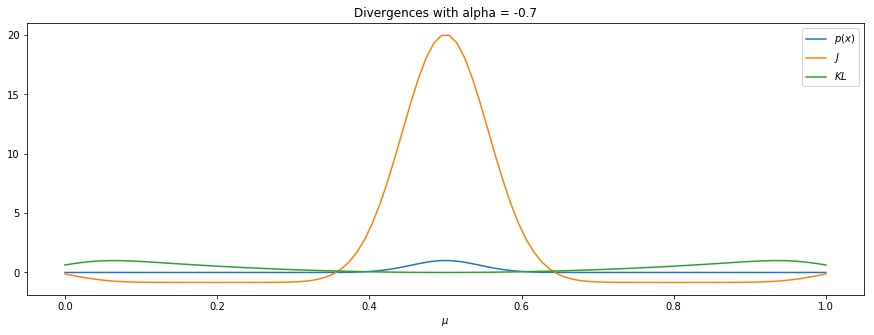

In [4]:
a = -0.7
j_vals = []
kl_vals = []
mus = np.linspace(0,1,100)
for mu in mus:
    j_vals.append(J(mu,p_sig,a)[0])
    kl_vals.append(KL(mu,p_sig)[0])
fig = plt.figure(figsize=(15,5))
p_vals = p(mus)
plt.plot(mus, p_vals/p_vals.max(), label="$p(x)$")
#plt.plot(mus, j_vals/np.max(np.abs(j_vals)), label='$J$')
plt.plot(mus, j_vals, label='$J$')
plt.plot(mus, kl_vals/np.max(np.abs(kl_vals)), label='$KL$')
plt.title("Divergences with alpha = {}".format(a))
plt.xlabel('$\mu$')
plt.legend()
plt.show()

# Derivative of Divergences as a function of $\mu_q$

As before we will vary $\mu_q$ but this time we are evaluating the derivatives of the divergence. We will hold $\sigma_q$ fixed to $\sigma_p$ and $\alpha = -0.5$.

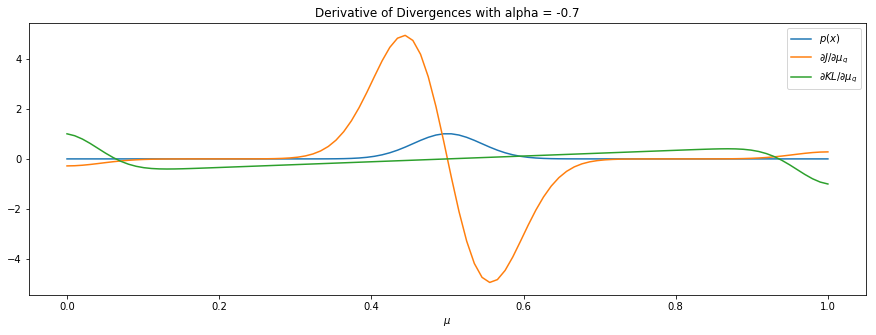

In [5]:
dj_vals = []
dkl_vals = []
mus = np.linspace(0,1.0,100)
for mu in mus:
    dj_vals.append(dJ_dmu(mu,p_sig,a)[0])
    dkl_vals.append(dKL_dmu(mu,p_sig)[0])
fig = plt.figure(figsize=(15,5))
p_vals = p(mus)
plt.plot(mus, p_vals/p_vals.max(), label="$p(x)$")
#plt.plot(mus, dj_vals/np.max(np.abs(dj_vals)), label='$\partial J/\partial \mu_q$')
plt.plot(mus, dj_vals, label='$\partial J/\partial \mu_q$')
plt.plot(mus, dkl_vals/np.max(np.abs(dkl_vals)), label='$\partial KL/\partial \mu_q$')
plt.title("Derivative of Divergences with alpha = {}".format(a))
plt.xlabel('$\mu$')
plt.legend()
plt.show()

# Finding the Zeros of the Derivatives

This is a little complicated becauase every step of the optimization algorithm requires the calculation of a quadrature. Error propagation could be an issue. To build confidence in the results we will find the location of the extrema as we increase the resolution around the extrema. If the value becomes more and more precise than we might believe that it is converging.

In [6]:
a = -0.7
j_optims = []
j_maxErrs = []
kl_optims = []
kl_maxErrs = []
tot_mus_list = [1000,2000,3000,4000,5000]
for tot_mus in tot_mus_list:
    print("Operating on {} mus...".format(tot_mus))
    dj_vals = []
    dj_errs = []
    dkl_vals = []
    dkl_errs = []
    mus = np.linspace(0.4,0.6,tot_mus)
    for mu in mus:
        j_quad, j_err = dJ_dmu(mu,p_sig,a)
        dj_vals.append(j_quad)
        dj_errs.append(j_err)
        kl_quad, kl_err = dKL_dmu(mu,p_sig)
        dkl_vals.append(kl_quad)
        dkl_errs.append(kl_err)
    j_optims.append(mus[np.argmin(np.abs(dj_vals))])
    j_maxErrs.append(np.max(dj_errs))
    kl_optims.append(mus[np.argmin(np.abs(dkl_vals))])
    kl_maxErrs.append(np.max(dkl_errs))

Operating on 1000 mus...
Operating on 2000 mus...
Operating on 3000 mus...
Operating on 4000 mus...
Operating on 5000 mus...


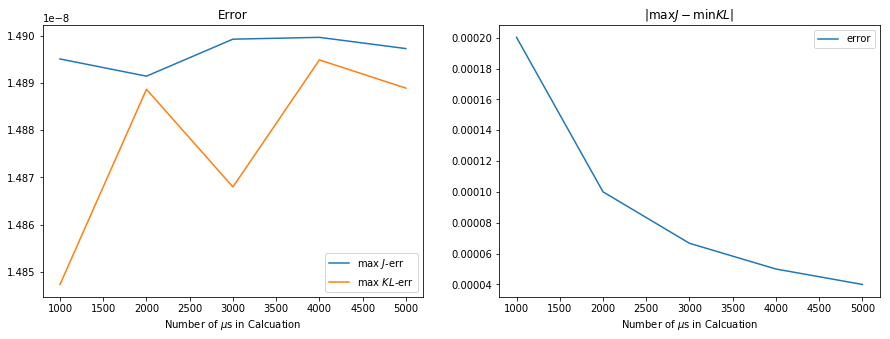

In [7]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title("Error")
ax1.set_xlabel("Number of $\mu$s in Calcuation")
ax1.plot(tot_mus_list, j_maxErrs, label="max $J$-err")
ax1.plot(tot_mus_list, kl_maxErrs, label="max $KL$-err")
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.set_title("$|\max{J}-\min{KL}|$")
ax2.set_xlabel("Number of $\mu$s in Calcuation")
ax2.plot(tot_mus_list, np.abs(np.array(j_optims)-np.array(kl_optims)), label="error")
ax2.legend()

# Examining the Divergences as a function of $\alpha$

This time we will fix both the means $\mu_q = \mu_p$ and variances $\sigma_q = \sigma_p$.

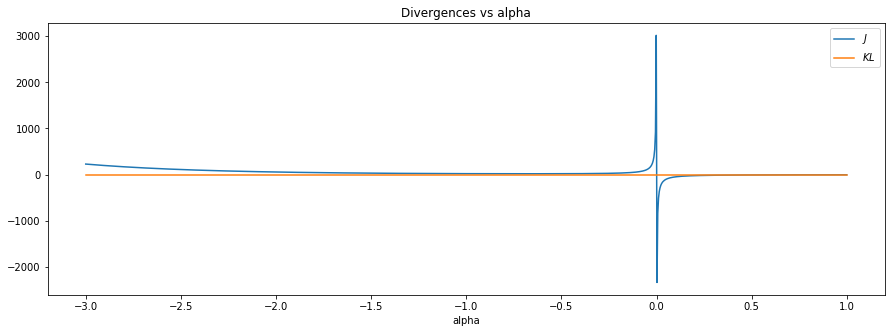

In [8]:
j_vals = []
kl_vals = []
alphas = np.linspace(-3,0.999,1000)
for a in alphas:
    j_vals.append(J(p_mean,p_sig,a)[0])
    kl_vals.append(KL(p_mean,p_sig)[0])
fig = plt.figure(figsize=(15,5))
plt.plot(alphas, j_vals, label='$J$')
plt.plot(alphas, kl_vals, label='$KL$')
plt.title("Divergences vs alpha")
plt.xlabel('alpha')
plt.legend()
plt.show()

# Derivatives of Divergences vs alpha

This is interesting but what we really care about is where $\alpha$ changes the extrema in anyway.

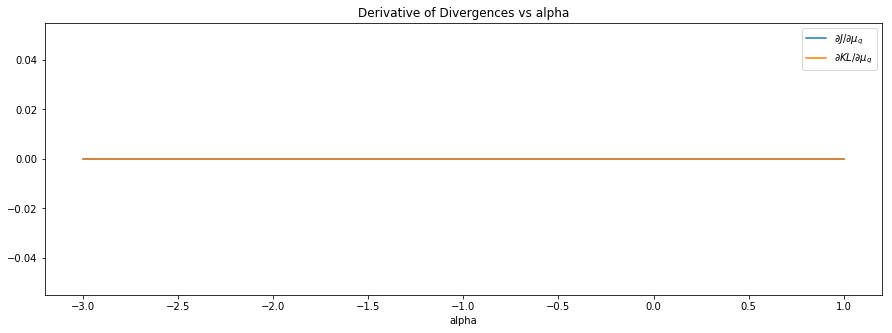

In [9]:
dj_vals = []
dkl_vals = []
alphas = np.linspace(-3,0.999,1000)
for a in alphas:
    dj_vals.append(dJ_dmu(p_mean,p_sig,a)[0])
    dkl_vals.append(dKL_dmu(p_mean,p_sig)[0])
fig = plt.figure(figsize=(15,5))
plt.plot(alphas, dj_vals, label='$\partial J/\partial \mu_q$')
plt.plot(alphas, dkl_vals, label='$\partial KL/\partial \mu_q$')
plt.title("Derivative of Divergences vs alpha")
plt.xlabel('alpha')
plt.legend()
plt.show()

# Cost Surface for the Convolution

Let us now examine the full function $f(\mu, \Sigma)$ for our given toy problem. We can explore how it changes as we modify the convolution with and without the entropy term.

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

mu_min = 0.4
mu_max = 0.6
num_mus = 1000
mus = np.linspace(mu_min, mu_max, num_mus)
sig_min = 0.0001
sig_max = 0.01
num_sigs = 1000
sigmas = np.linspace(sig_min, sig_max, num_sigs)
mu,sigma = np.meshgrid(mus,sigmas)
vals = np.array((mu,sigma))
z = np.ndarray(mu.shape)
for i in range(len(mu[0])):
    for j in range(len(sigma[0])):
        m,s = vals[:,i,j]
        z[i,j] = J(m,s,-0.7)[0]

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.gca(projection='3d')
ax.plot_surface(mu, sigma, z, rstride=5, cstride=5, alpha=0.3)
cset = ax.contour(mu, sigma, z, zdir='z', offset=-0.1, cmap=cm.coolwarm)
cset = ax.contour(mu, sigma, z, zdir='x', offset=mu_min, cmap=cm.coolwarm)
cset = ax.contour(mu, sigma, z, zdir='y', offset=sig_max, cmap=cm.coolwarm)

ax.set_xlabel('$\mu$')
ax.set_xlim(mu_min, mu_max)
ax.set_ylabel('$\sigma$')
ax.set_ylim(sig_min, sig_max)
ax.set_zlabel('$f$')
ax.set_zlim(-0.1,100)

plt.show()

In [60]:
z[0,0]

-0.1260520058656194

In [62]:
len(np.where(np.isnan(z))[0])

0